In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mellaniasylvie","key":"7d9b130cb8bf219918fd1ce5a04bebe6"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset

 99% 657M/663M [00:09<00:00, 81.8MB/s]
100% 663M/663M [00:09<00:00, 70.0MB/s]


In [9]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import zipfile
import os

In [10]:
local_zip = '/content/tuberculosis-tb-chest-xray-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
base_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(base_dir, 'Normal')
tbc_dir = os.path.join(base_dir, 'Tuberculosis')

In [12]:
print('Jumlah data tbc :',len(os.listdir(tbc_dir)))
print('Jumlah data normal :',len(os.listdir(normal_dir)))

Jumlah data tbc : 700
Jumlah data normal : 3500


In [13]:
TBC_Dataset = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  image_size=(150, 150)
  )

Found 4200 files belonging to 2 classes.


In [15]:
class_names = TBC_Dataset.class_names
print(class_names)

['Normal', 'Tuberculosis']


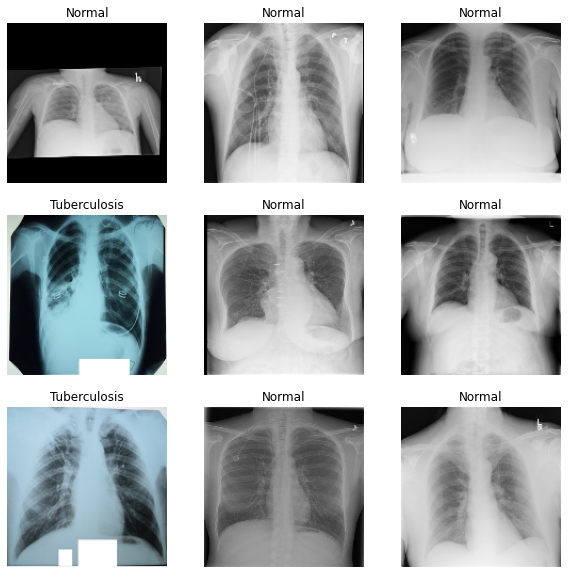

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in TBC_Dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2
                                   )
    
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range = 20,
                                        validation_split=0.2
                                        )

In [21]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size= 32,
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size= 32,
    subset='validation'
)

Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [22]:
from sklearn.utils import class_weight 
from sklearn.utils import compute_class_weight
import numpy as np

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes)
class_weights = dict(zip(np.unique(train_classes), class_weights)),
class_weights

({0: 0.6, 1: 3.0},)

In [28]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 32)                2

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [31]:
history = model.fit(train_generator, 
                    epochs=25, 
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr],
                    shuffle = True)

Epoch 1/25
105/105 [==============================] - 148s 1s/step - loss: 0.4074 - accuracy: 0.8512 - val_loss: 0.3476 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/25
105/105 [==============================] - 147s 1s/step - loss: 0.2662 - accuracy: 0.9134 - val_loss: 0.2259 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/25
105/105 [==============================] - 150s 1s/step - loss: 0.2888 - accuracy: 0.8982 - val_loss: 0.2285 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/25
105/105 [==============================] - 148s 1s/step - loss: 0.2248 - accuracy: 0.9223 - val_loss: 0.1791 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 5/25
105/105 [==============================] - 147s 1s/step - loss: 0.1921 - accuracy: 0.9408 - val_loss: 0.1902 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 6/25
105/105 [==============================] - 146s 1s/step - loss: 0.1891 - accuracy: 0.9348 - val_loss: 0.1440 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 7/25
105/105 [==============================] - 150s 1s/st

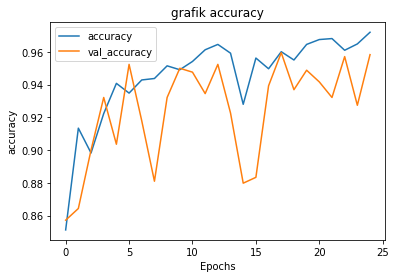

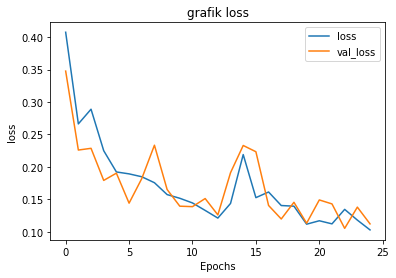

In [32]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
grafik_plot(history, "accuracy")
grafik_plot(history, "loss")

Saving Tuberculosis-658.png to Tuberculosis-658.png
Tuberculosis-658.png
[[1.]]
Tuberkulosis


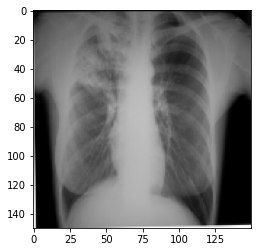

In [45]:
# memprediksi gambar yang diupload ke dalam notebook
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded_files = files.upload()
 
for pic in uploaded_files.keys():
  path = pic
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  
  print(pic)
  print(classes)
  if classes==0:
   print('Normal')
  else:
   print('Tuberkulosis')

In [46]:
if __name__ == '__main__':
    model.save("model_capstone.h5")